## Importación librerías

In [1]:
from utilities.constants import Path
from utilities.constants import TYPE_COLS
from utilities.constants import STYLE_COLOR
from utilities.constants import Color as color
from utilities.functions import castTypeCols
from utilities.functions import statisticsNulls
from utilities.functions import instanceSimplePlot
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

## Carga de dataset

In [2]:
test = pd.read_csv(Path.TEST.value)
train = pd.read_csv(Path.TRAIN.value)

# Merge inicial para fase exploratoria
data = pd.concat([train, test], axis=0, ignore_index=True)
data = castTypeCols(data=data, dtype=TYPE_COLS)

## Exploración de datos

### Gestión de nulos

#### Variables Continuas

In [3]:
statisticsNulls(data.loc[:, TYPE_COLS.get('continuos')])

""" Estadísticas de Nulos: """
Hay 514 / 55461 de registros nulos, un 0.93% sobre el total.
Hay 505 / 2919 filas con al menos un nulo, un 17.30% sobre el total.

""" Top 10 variables con nulos """
LotFrontage    486
MasVnrArea      23
BsmtFinSF1       1
BsmtFinSF2       1
BsmtUnfSF        1
TotalBsmtSF      1
GarageArea       1
OpenPorchSF      0
PoolArea         0
ScreenPorch      0
dtype: int64


In [4]:
# Control de correlación sobre la variable LotFrontage para ver si se puede inferrir los nulos
(data
    .loc[:, TYPE_COLS.get('continuos') + TYPE_COLS.get('discrete')]
    .corr()
    .iloc[0]
    .sort_values(ascending=False)
    .iloc[:10]
)

LotFrontage     1.000000
LotArea         0.489896
1stFlrSF        0.458247
GrLivArea       0.382462
GarageArea      0.359786
TotalBsmtSF     0.354822
TotRmsAbvGrd    0.349513
GarageCars      0.310587
Fireplaces      0.261970
BedroomAbvGr    0.234892
Name: LotFrontage, dtype: float64

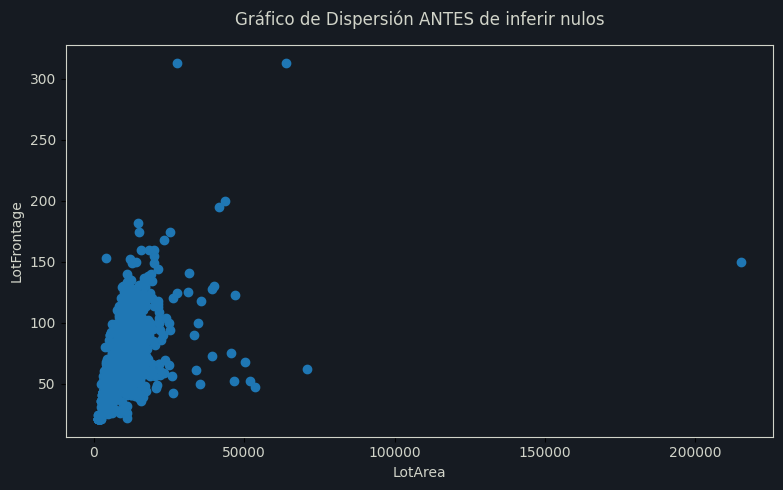

In [5]:
text_plot = {
    'title': 'Gráfico de Dispersión ANTES de inferir nulos',
    'xlabel': 'LotArea',
    'ylabel': 'LotFrontage'
}

instanceSimplePlot(text_plot, STYLE_COLOR)
plt.scatter(x=data['LotArea'], y=data['LotFrontage'])
plt.show()

In [6]:
'''
    Hay cierto grado de correlación entre las variables LotFrontage, LotArea y 1stFlrSF
    Para este notebook voy a inferir los nulos a través de la librería scikit-learn
    con una regresión lineal.

    En realidad se debería de hacer una valoración más exaustiva sobre si, como parece,
    no debería de haber nulos en esta variable.

    También un mayor control sobre el rendimiento de la inferencia, a simple vista de scatter
    da la sensación de generación de ruido en la predicción. Se debería de probar distintas
    estrategias y tener un mayor conocimiento para la correcta verificación.
'''
# Filtra los datos de las variables con correlación
cols = ['LotFrontage', 'LotArea', '1stFlrSF']
df = data.loc[:, cols]

# Crea los datos de entrenamiento y predicción
mask = df.LotFrontage.isnull()
X_nulls = df.loc[mask, ['LotArea', '1stFlrSF']]
X = df.loc[~mask, ['LotArea', '1stFlrSF']]
y = df.loc[~mask, 'LotFrontage']

# Entrenamiento del modelo
mdl = LinearRegression().fit(X, y)

# Predicción de la variable objetivo LotFrontage
predicted_values = mdl.predict(X_nulls)
data.loc[mask, 'LotFrontage'] = predicted_values

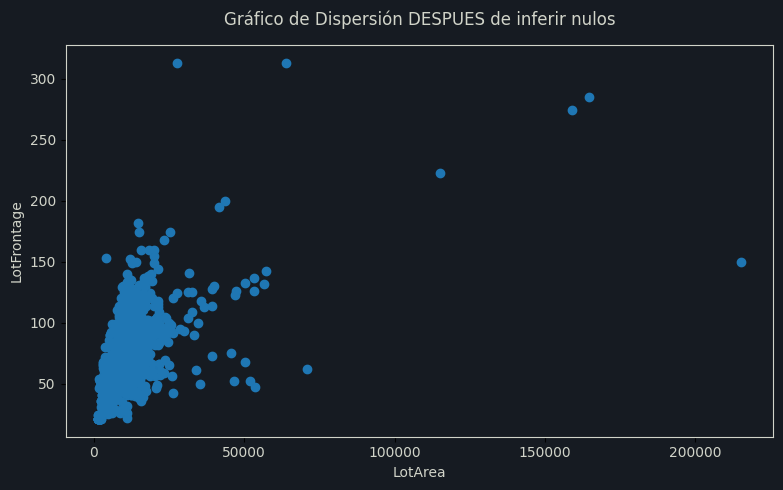

In [7]:
text_plot = {
    'title': 'Gráfico de Dispersión DESPUES de inferir nulos',
    'xlabel': 'LotArea',
    'ylabel': 'LotFrontage'
}

instanceSimplePlot(text_plot, STYLE_COLOR)
plt.scatter(x=data['LotArea'], y=data['LotFrontage'])
plt.show()

In [8]:
'''
    Eliminación del resto de nulos
    Por número y por correlación con el resto, decido su eliminación del dataset
'''
cols_drop = [
    'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'GarageArea'
]
mask = data.loc[:, cols_drop].isnull().T.any()
data.drop(data.loc[mask].index, axis=0, inplace=True)
data.reset_index(drop=True, inplace=True)

In [9]:
statisticsNulls(data.loc[:, TYPE_COLS.get('continuos')])

""" Estadísticas de Nulos: """
Hay 0 / 54986 de registros nulos, un 0.00% sobre el total.
Hay 0 / 2894 filas con al menos un nulo, un 0.00% sobre el total.


#### Variables Discretas

In [10]:
statisticsNulls(data.loc[:, TYPE_COLS.get('discrete')])

""" Estadísticas de Nulos: """
Hay 159 / 40516 de registros nulos, un 0.39% sobre el total.
Hay 158 / 2894 filas con al menos un nulo, un 5.46% sobre el total.

""" Top 10 variables con nulos """
GarageYrBlt     157
BsmtFullBath      1
BsmtHalfBath      1
YearBuilt         0
YearRemodAdd      0
FullBath          0
HalfBath          0
BedroomAbvGr      0
KitchenAbvGr      0
TotRmsAbvGrd      0
dtype: int64


In [11]:
# Correlación de todas la características que incluyen año
data.loc[:, ['GarageYrBlt', 'YearBuilt', 'YearRemodAdd']].corr()

,GarageYrBlt,YearBuilt,YearRemodAdd
GarageYrBlt,1.000000,0.842342,0.655780
YearBuilt,0.842342,1.000000,0.609552
YearRemodAdd,0.655780,0.609552,1.000000


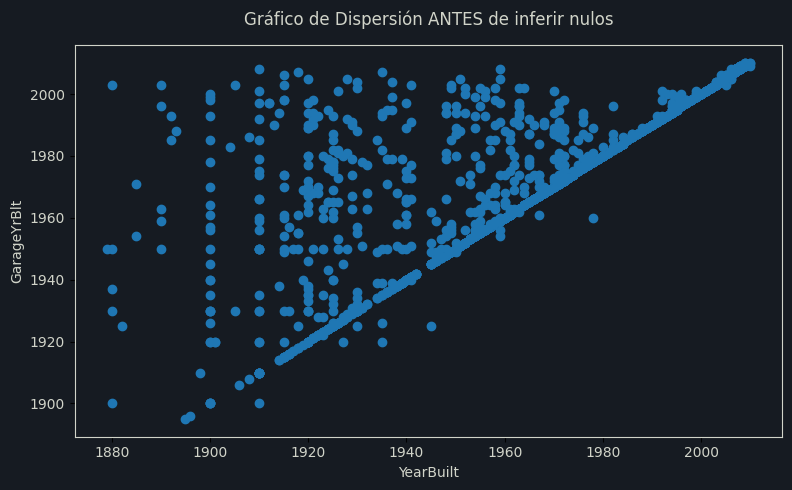

In [12]:
text_plot = {
    'title': 'Gráfico de Dispersión ANTES de inferir nulos',
    'xlabel': 'YearBuilt',
    'ylabel': 'GarageYrBlt'
}

instanceSimplePlot(text_plot, STYLE_COLOR)
plt.scatter(x=data['YearBuilt'], y=data['GarageYrBlt'])
plt.show()

In [13]:
'''
    Se muestra una buena correlación entre el año de construcción de la casa y el de la construcción del garage
    Tiene bastante sentido, a priori, tratar de predecir los nulos de la variable GarageYrBlt con YearBuilt y YearRemodAdd
'''
# Filtra los datos de las variables con correlación
cols = ['GarageYrBlt', 'YearBuilt', 'YearRemodAdd']
df = data.loc[:, cols]

# Crea los datos de entrenamiento y predicción
mask = df.GarageYrBlt.isnull()
X_nulls = df.loc[mask, ['YearBuilt', 'YearRemodAdd']]
X = df.loc[~mask, ['YearBuilt', 'YearRemodAdd']]
y = df.loc[~mask, 'GarageYrBlt']

# Entrenamiento del modelo
mdl = LinearRegression().fit(X, y)

# Predicción de la variable objetivo LotFrontage
predicted_values = mdl.predict(X_nulls)
data.loc[mask, 'GarageYrBlt'] = predicted_values

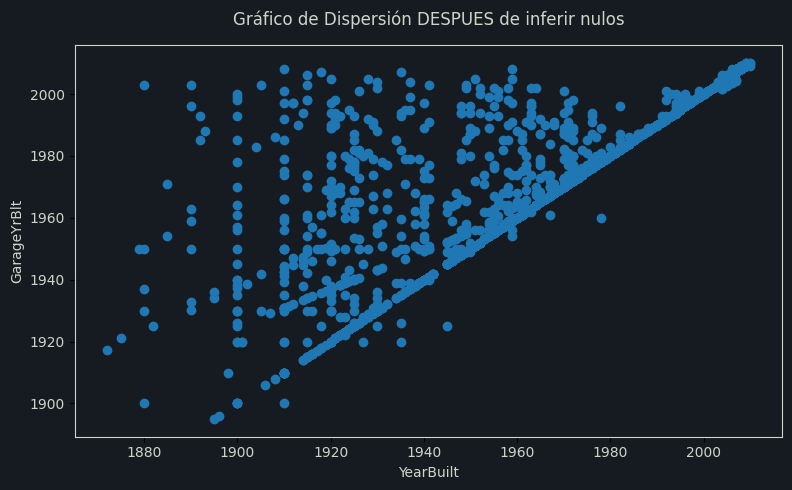

In [14]:
text_plot = {
    'title': 'Gráfico de Dispersión DESPUES de inferir nulos',
    'xlabel': 'YearBuilt',
    'ylabel': 'GarageYrBlt'
}

instanceSimplePlot(text_plot, STYLE_COLOR)
plt.scatter(x=data['YearBuilt'], y=data['GarageYrBlt'])
plt.show()

In [15]:
'''
    Eliminación del resto de nulos
    Por número y por correlación con el resto, decido su eliminación del dataset
'''
cols_drop = [
    'BsmtFullBath', 'BsmtHalfBath'
]
mask = data.loc[:, cols_drop].isnull().T.any()
data.drop(data.loc[mask].index, axis=0, inplace=True)
data.reset_index(drop=True, inplace=True)

In [16]:
statisticsNulls(data.loc[:, TYPE_COLS.get('discrete')])

""" Estadísticas de Nulos: """
Hay 0 / 40502 de registros nulos, un 0.00% sobre el total.
Hay 0 / 2893 filas con al menos un nulo, un 0.00% sobre el total.


#### Variable Categóricas

In [17]:
statisticsNulls(data.loc[:, TYPE_COLS.get('categorical')])

""" Estadísticas de Nulos: """
Hay 0 / 133078 de registros nulos, un 0.00% sobre el total.
Hay 0 / 2893 filas con al menos un nulo, un 0.00% sobre el total.


### Gestión outliers

In [18]:
data.describe().iloc[:, :18]

,Id,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath
count,2893.000000,2893.000000,2893.000000,2893.000000,2893.000000,2893.000000,2893.000000,2893.000000,2893.000000,2893.000000,2893.000000,2893.000000,2893.000000,2893.000000,2893.000000,2893.000000,2893.000000,2893.000000
mean,1456.689941,69.957183,10150.739371,1971.093329,1984.112340,102.307293,441.365365,49.908054,559.774628,1051.048047,1158.211545,335.827515,4.736606,1498.775665,0.430003,0.061873,1.563775,0.377809
std,843.012974,22.826373,7876.964069,30.266993,20.894655,179.397017,455.276588,169.812725,439.110166,440.453056,388.869836,428.419764,46.602774,505.106659,0.524990,0.246640,0.551461,0.501745
min,1.000000,21.000000,1300.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000
25%,727.000000,60.000000,7449.000000,1953.000000,1965.000000,0.000000,0.000000,0.000000,220.000000,792.000000,876.000000,0.000000,0.000000,1124.000000,0.000000,0.000000,1.000000,0.000000
50%,1455.000000,68.963887,9452.000000,1973.000000,1993.000000,0.000000,368.000000,0.000000,467.000000,989.000000,1082.000000,0.000000,0.000000,1442.000000,0.000000,0.000000,2.000000,0.000000
75%,2185.000000,80.000000,11553.000000,2000.000000,2004.000000,164.000000,733.000000,0.000000,801.000000,1300.000000,1383.000000,703.000000,0.000000,1742.000000,1.000000,0.000000,2.000000,1.000000
max,2919.000000,313.000000,215245.000000,2010.000000,2010.000000,1600.000000,5644.000000,1526.000000,2336.000000,6110.000000,5095.000000,2065.000000,1064.000000,5642.000000,3.000000,2.000000,4.000000,2.000000


In [19]:
data.describe().iloc[:, 18:]

,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,2893.000000,2893.00000,2893.000000,2893.000000,2893.000000,2893.000000,2893.000000,2893.000000,2893.000000,2893.000000,2893.000000,2893.000000,2893.000000,2893.000000,2893.000000,2893.000000,1452.000000
mean,2.860353,1.04459,6.450743,0.596267,1976.754092,1.764259,472.342551,93.965434,47.097822,23.094366,2.625648,16.206706,2.272036,51.282751,6.204632,2007.794677,180615.063361
std,0.822737,0.21465,1.569531,0.645883,25.383402,0.762454,215.596536,126.785187,67.131189,64.235544,25.299927,56.415620,35.823260,569.926509,2.711895,1.316986,79285.541485
min,0.000000,0.00000,2.000000,0.000000,1895.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,2.000000,1.00000,5.000000,0.000000,1959.000000,1.000000,319.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000,129900.000000
50%,3.000000,1.00000,6.000000,1.000000,1978.000000,2.000000,478.000000,0.000000,26.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,162700.000000
75%,3.000000,1.00000,7.000000,1.000000,2001.000000,2.000000,576.000000,168.000000,69.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,8.000000,3.00000,15.000000,4.000000,2010.000000,5.000000,1488.000000,1424.000000,742.000000,1012.000000,508.000000,576.000000,800.000000,17000.000000,12.000000,2010.000000,755000.000000


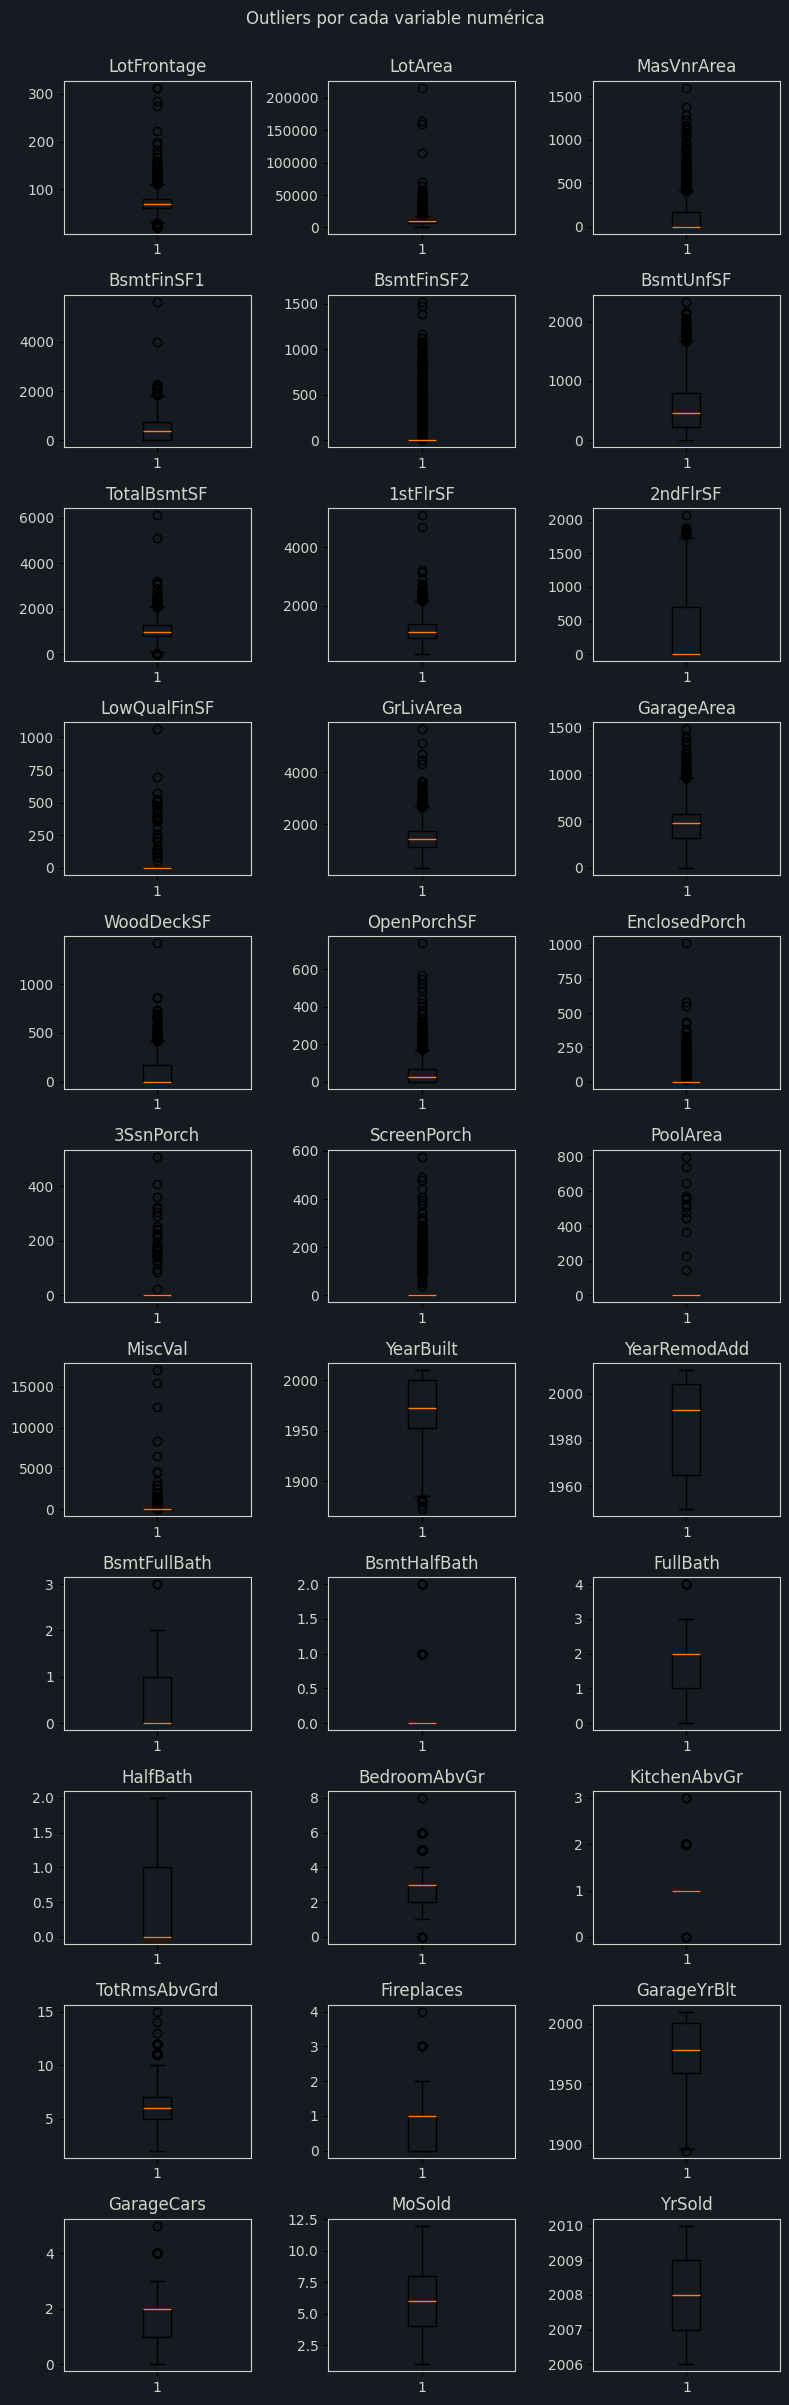

In [20]:
cols = TYPE_COLS.get('continuos') + TYPE_COLS.get('discrete')
df = data.loc[:, cols]

fig, axes = plt.subplots(nrows=11, ncols=3, figsize=(8, 24))
fig.set_facecolor(color.DARK.value)
fig.suptitle(t='Outliers por cada variable numérica', y=1, color=color.WHITE.value)

for i, ax in enumerate(axes.flatten()):
    ax.boxplot(df.iloc[:, i])
    ax.set_title(f'{ df.columns[i] }', color=color.WHITE.value)

    ax.set_facecolor(color.DARK.value)
    ax.tick_params(axis='y', labelcolor=color.WHITE.value)
    ax.tick_params(axis='x', labelcolor=color.WHITE.value)
    ax.spines['bottom'].set_color(color.WHITE.value)
    ax.spines['top'].set_color(color.WHITE.value)
    ax.spines['left'].set_color(color.WHITE.value)
    ax.spines['right'].set_color(color.WHITE.value)

fig.tight_layout()
plt.show()

In [21]:
'''
    Después de analizar los posibles outliers, decido no descartar ningún registro. No parece que haya ningún
    dato erróneo, al menos desde mi conocimiento en el campo inmobiliario. 
    En un proyecto real, habría que realizar un estudio más exhaustivo al respecto.
''';

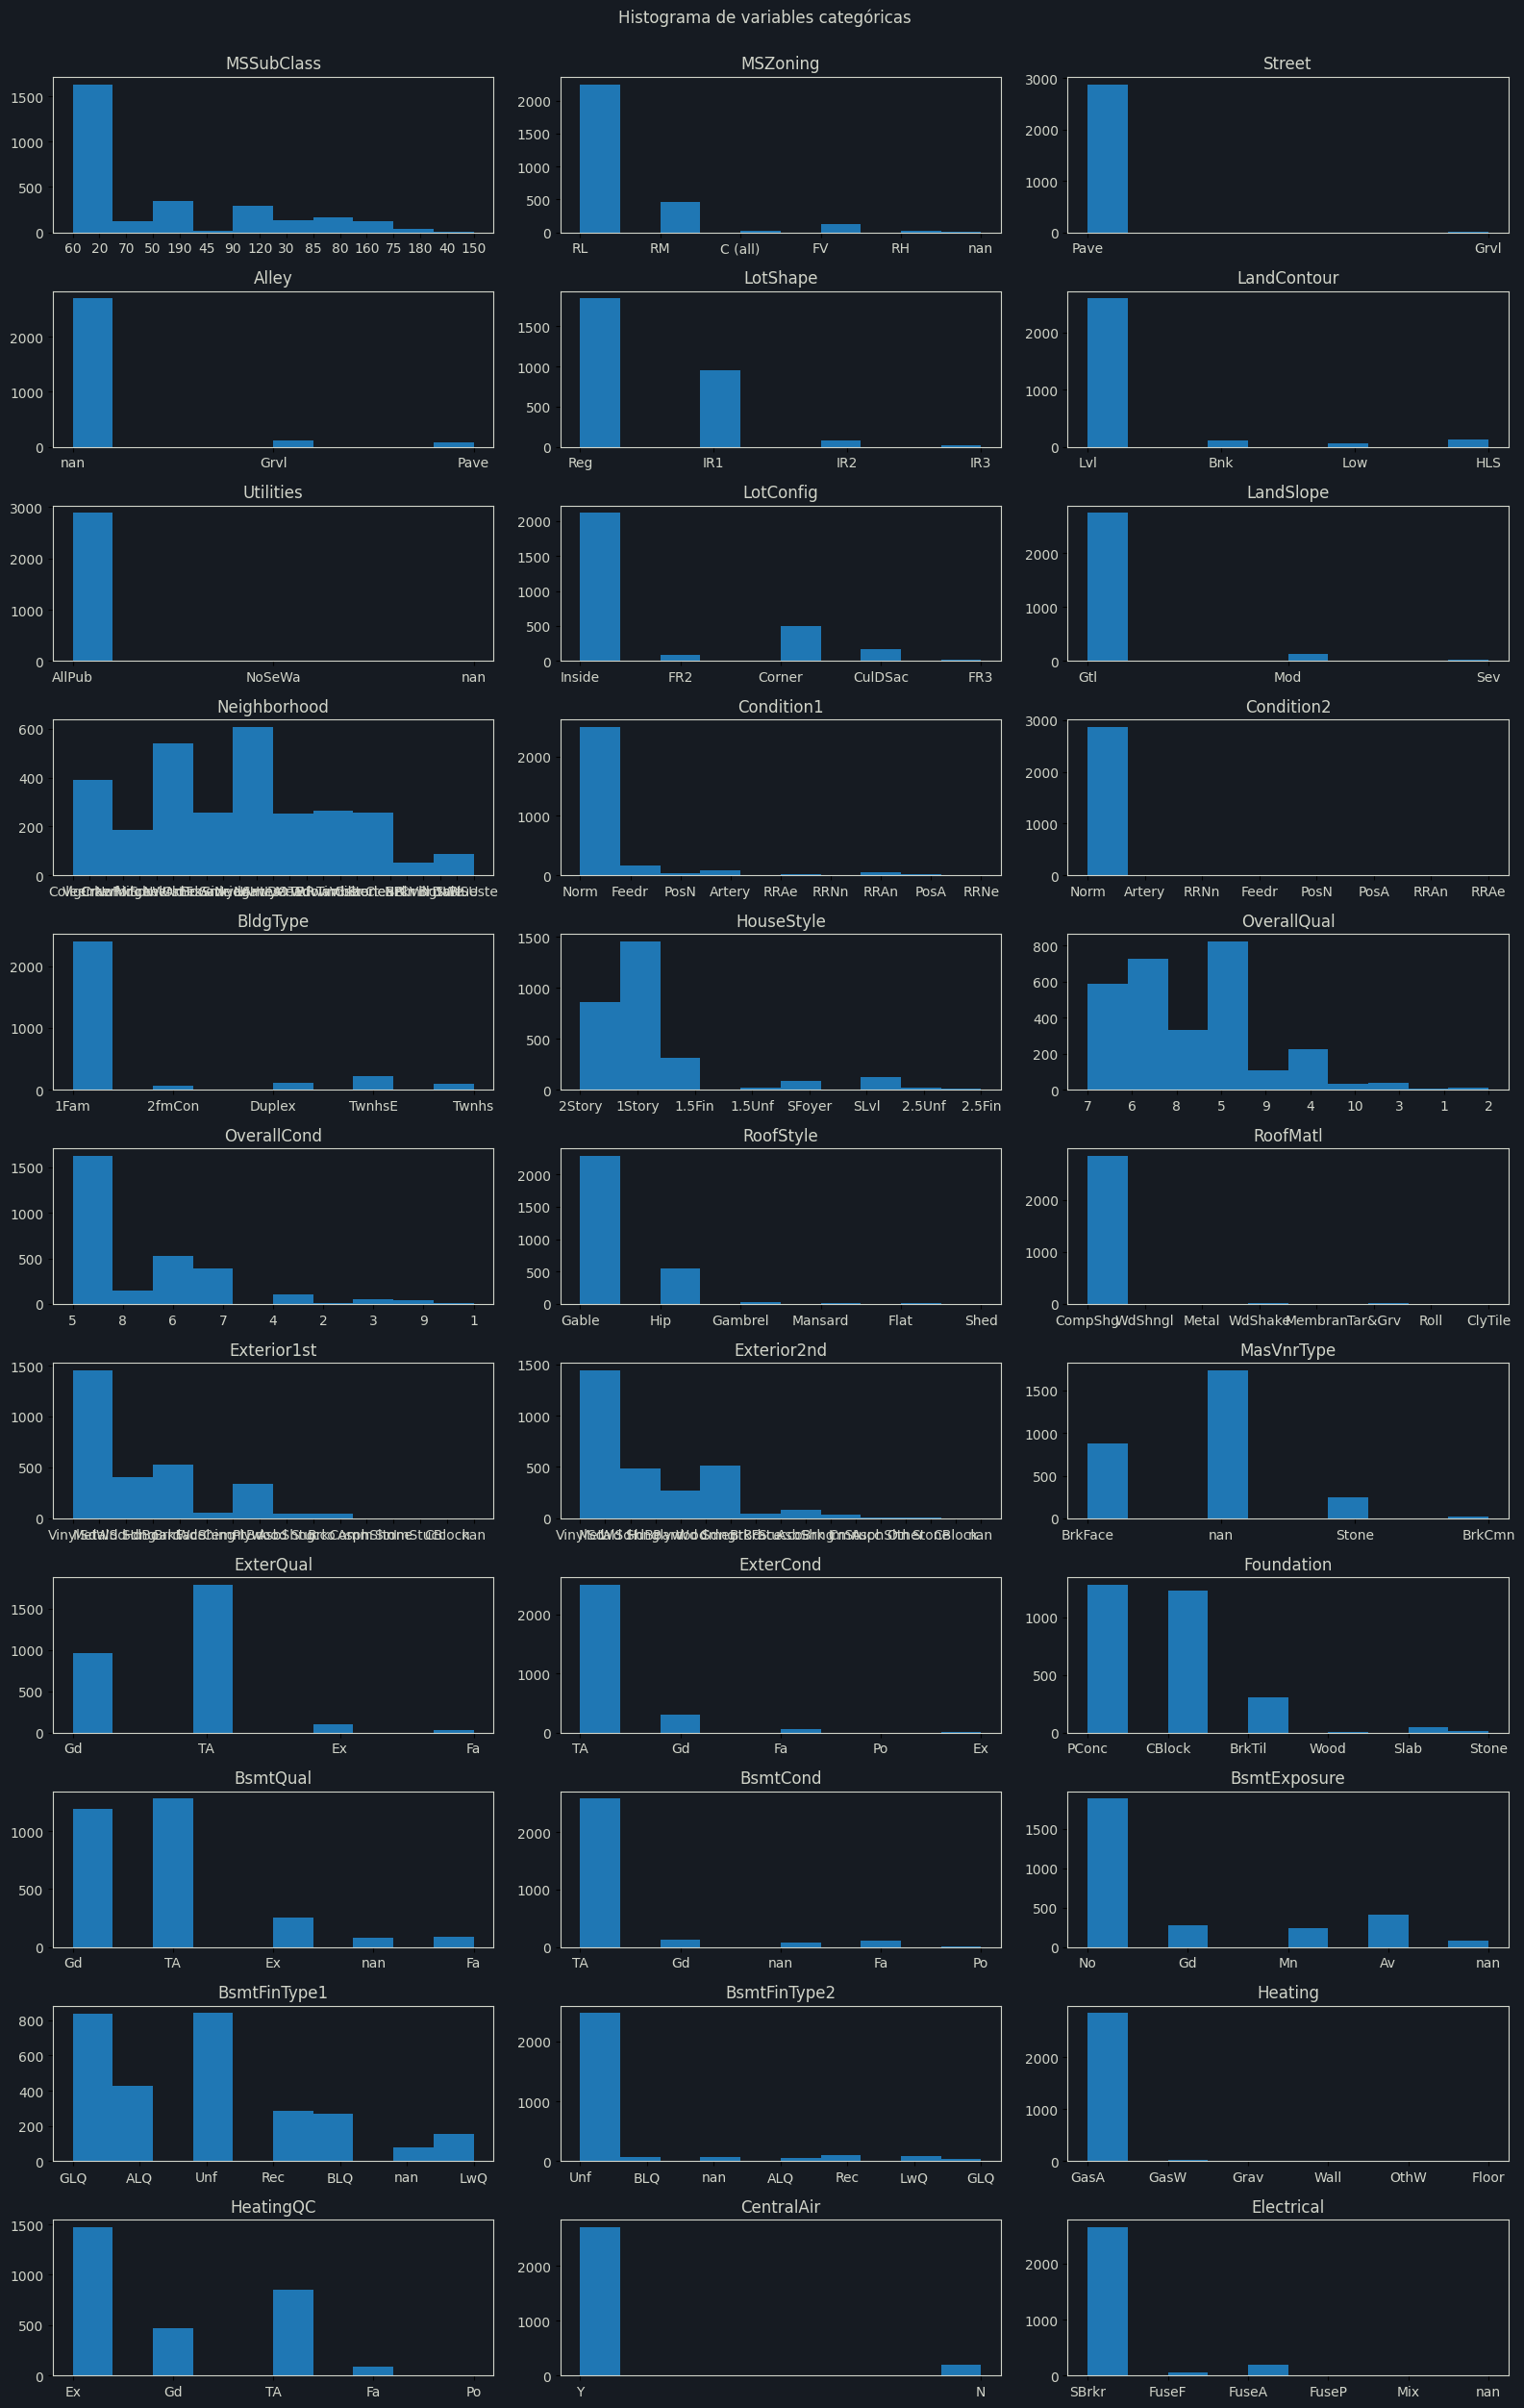

In [22]:
cols = TYPE_COLS.get('categorical')
df = data.loc[:, cols]

fig, axes = plt.subplots(nrows=11, ncols=3, figsize=(16, 25))
fig.set_facecolor(color.DARK.value)
fig.suptitle(t='Histograma de variables categóricas', y=1, color=color.WHITE.value)

for i, ax in enumerate(axes.flatten()):
    ax.hist(df.iloc[:, i])
    ax.set_title(f'{ df.columns[i] }', color=color.WHITE.value)

    ax.set_facecolor(color.DARK.value)
    ax.tick_params(axis='y', labelcolor=color.WHITE.value)
    ax.tick_params(axis='x', labelcolor=color.WHITE.value)
    ax.spines['bottom'].set_color(color.WHITE.value)
    ax.spines['top'].set_color(color.WHITE.value)
    ax.spines['left'].set_color(color.WHITE.value)
    ax.spines['right'].set_color(color.WHITE.value)

fig.tight_layout()
plt.show()

## Exportar datos

In [23]:
mask = data.SalePrice.isnull()

# Exportar los datos de entrenamiento
data[~mask].to_csv(Path.PATH.value + 'train_clean.csv', index=False)

# Exportar los datos de test
data[mask].to_csv(Path.PATH.value + 'test_clean.csv', index=False)